Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [9]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import time
import random
import matplotlib.pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [10]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f, encoding='latin1') # Add encoding for Py3
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


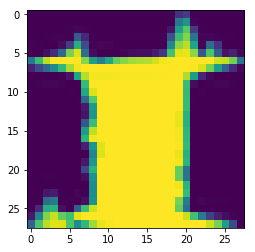

I


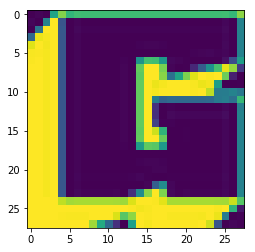

G


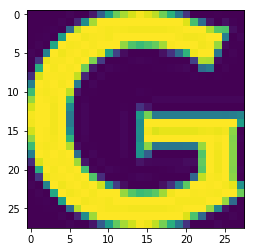

G


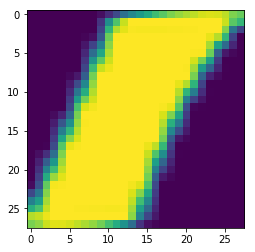

I


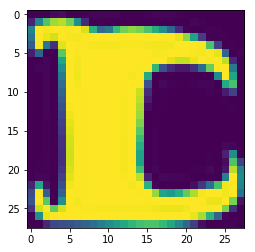

C


In [16]:
def verify_from_notMNIST_pickle(total_check, train_data, train_label):
    for i in range(total_check):
        random_index = random.randint(1, train_data.shape[0])
        image_data = train_data[random_index]
        plt.imshow(image_data)
        plt.show()
        print (chr(ord('A')+train_label[random_index]))
verify_from_notMNIST_pickle(5, train_dataset, train_labels)
print('mean: %f' % (np.mean(train_dataset, )))

Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    # what happens when the new shape for reshape function see '-1'??
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape, train_dataset.nbytes, train_labels.nbytes)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10) 627200000 8000000
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [5]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 200000

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random valued following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    # logits----------->softmax----->+
    # targets------------------------+--->cross-entropy
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [6]:
num_steps = 801

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.global_variables_initializer().run()
    print('Initialized')
    be_t = time.time()
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %3d: train: %.1f%%, validate: %.1f%%, loss: %f' % 
                  (step, accuracy(predictions, train_labels[:train_subset, :])
                   ,accuracy(valid_prediction.eval(), valid_labels), l))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
    en_t = time.time()
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    print('take time: %.1f'%(en_t - be_t))

Initialized
Loss at step   0: train: 10.0%, validate: 10.0%, loss: 21.530632
Loss at step 100: train: 10.0%, validate: 10.0%, loss: 41.776958
Loss at step 200: train: 10.0%, validate: 10.0%, loss: 42.173599
Loss at step 300: train: 10.0%, validate: 10.0%, loss: 42.422306
Loss at step 400: train: 10.0%, validate: 10.0%, loss: 42.613289
Loss at step 500: train: 10.0%, validate: 10.0%, loss: 42.773109
Loss at step 600: train: 10.0%, validate: 10.0%, loss: 42.913544
Loss at step 700: train: 10.0%, validate: 10.0%, loss: 43.042046
Loss at step 800: train: 10.0%, validate: 10.0%, loss: 43.159672
Test accuracy: 10.0%
take time: 632.7


Let's now switch to `stochastic gradient descent` training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [16]:
batch_size = 200

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [17]:
num_steps = 1001

def accuracy2(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  begin_time = time.time()
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      step_end_time = time.time()
      print("Minibatch loss at step %d: %f, time: %f" % (step, l, step_end_time - begin_time))
      print("Minibatch accuracy: %.1f%%" % accuracy2(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy2(valid_prediction.eval(), valid_labels))

  print("Test accuracy: %.1f%%" % accuracy2(test_prediction.eval(), test_labels))
  end_time = time.time()
  print("Spent time: %f"%(end_time - begin_time))

Initialized
Minibatch loss at step 0: 15.518747, time: 0.003943
Minibatch accuracy: 8.5%
Validation accuracy: 13.7%
Minibatch loss at step 100: 1.828720, time: 0.237534
Minibatch accuracy: 71.0%
Validation accuracy: 71.6%
Minibatch loss at step 200: 1.974067, time: 0.453564
Minibatch accuracy: 76.0%
Validation accuracy: 74.3%
Minibatch loss at step 300: 2.060050, time: 0.661129
Minibatch accuracy: 73.5%
Validation accuracy: 74.6%
Minibatch loss at step 400: 1.757438, time: 0.864913
Minibatch accuracy: 76.5%
Validation accuracy: 75.6%
Minibatch loss at step 500: 1.539635, time: 1.071274
Minibatch accuracy: 79.0%
Validation accuracy: 75.3%
Minibatch loss at step 600: 1.693435, time: 1.276970
Minibatch accuracy: 70.5%
Validation accuracy: 75.1%
Minibatch loss at step 700: 1.452281, time: 1.490275
Minibatch accuracy: 77.5%
Validation accuracy: 76.1%
Minibatch loss at step 800: 1.255659, time: 1.703543
Minibatch accuracy: 78.5%
Validation accuracy: 76.7%
Minibatch loss at step 900: 1.504811

---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

Solution to the problem, I am going to re-write the training graph that add 1-hidden layer and using 1024 hidden nodes. 
This is the starting work of Deep Learning with 1-hidden layers

In [18]:
batch_size = 200

graph = tf.Graph()
with graph.as_default():
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Layer 1 Variables.
  weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, 1024]))
  biases1 = tf.Variable(tf.zeros([1024]))
  # Layer 2 Variables
  weights2 = tf.Variable(tf.truncated_normal([1024, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # logits = tf.matmul(tf_train_dataset, weights1) + biases1
  hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(hidden, weights2) + biases2
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_pred1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_pred1, weights2) + biases2)
  test_pred1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(test_pred1, weights2) + biases2)

In [20]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy2(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy2(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy2(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 393.072113
Minibatch accuracy: 8.0%
Validation accuracy: 26.4%
Minibatch loss at step 500: 7.915215
Minibatch accuracy: 82.0%
Validation accuracy: 82.3%
Minibatch loss at step 1000: 4.325796
Minibatch accuracy: 87.0%
Validation accuracy: 82.3%
Test accuracy: 89.1%
